Доброго времени! Задачу решил, но не вполне верно. Хорошо бы попробовать с TensorFlow/Keras, но на это нет времени...

<ipython-input-12-1fa5183d42c2>:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)
<ipython-input-12-1fa5183d42c2>:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pivot_table.index = pd.date_range(start=pivot_table.index.min(), periods=len(pivot_table), freq='M')


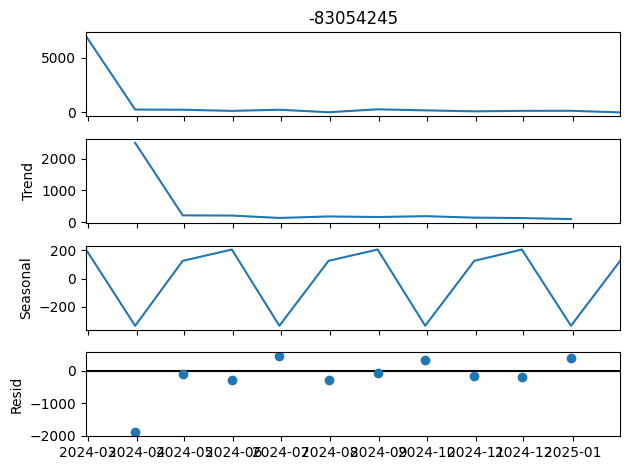

            Прогноз на январь          MAE
-83054245               45.95  2292.150000
 44403861               45.87  1362.510000
 95166060               89.07   658.570000
 126373749             111.84  2189.336667
 304773881              40.32  2462.170000
 440376223             111.73  1163.076667
 678167538              52.61  2070.786667
 811003631              55.29  1126.856667
 879714109             156.86  1725.776667
 905559214             145.79  2785.913333


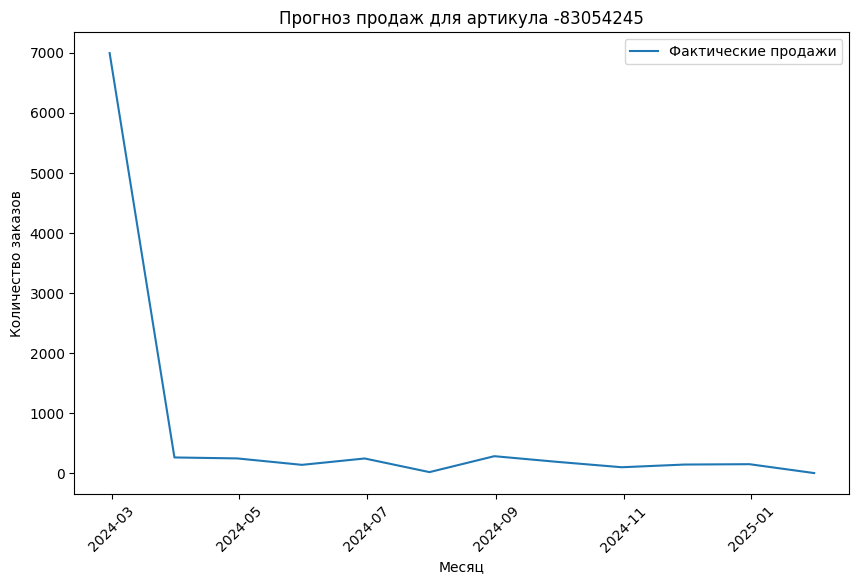

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

# Загрузка данных из Google Sheets
spreadsheet_id = "1xV8U_ajS03PlklvC_rqbN0-wH3cnUMAccM63ffm5-Zk"
sheet_gid = "0"
url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&gid={sheet_gid}"

df = pd.read_csv(url)

# Преобразование столбца updated_at в формат datetime
df['updated_at'] = pd.to_datetime(df['updated_at'])

df['year_month'] = pd.to_datetime(df['updated_at']).dt.to_period('M').dt.to_timestamp()
pivot_table = df.pivot_table(index='year_month', columns='nm_id', aggfunc='size', fill_value=0)
pivot_table.index = pd.date_range(start=pivot_table.index.min(), periods=len(pivot_table), freq='M')

# Функция для разложения временного ряда и визуализации компонентов

def decompose_time_series(ts, model='additive', period=3):
    decomposition = sm.tsa.seasonal_decompose(ts, model=model, period=period)
    fig = decomposition.plot()
    plt.show()


# Пример разложения для одного из артикулов
sample_article = pivot_table.columns[0]
decompose_time_series(pivot_table[sample_article])

# Подготовка данных для модели
X = np.array([i for i in range(len(pivot_table))]).reshape(-1, 1)
pred_month = np.array([[len(pivot_table)]])

# Функция для прогнозирования продаж на следующий месяц
def forecast_sales(article_series):
    y = article_series.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    forecast = model.predict(pred_month)
    return forecast[0], mae

# Прогнозирование продаж на январь для каждого артикула
forecasts = {}
for article in pivot_table.columns:
    forecast, mae = forecast_sales(pivot_table[article])
    forecasts[article] = {'forecast': forecast, 'mae': mae}

# Вывод прогнозов
forecast_df = pd.DataFrame(forecasts).T
forecast_df.columns = ['Прогноз на январь', 'MAE']
print(forecast_df)

# Визуализация фактических и прогнозируемых значений для примера
plt.figure(figsize=(10, 6))
plt.plot(pivot_table[sample_article], label='Фактические продажи')
plt.title(f'Прогноз продаж для артикула {sample_article}')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend()
plt.xticks(rotation=45)
plt.show()
